<a href="https://colab.research.google.com/github/rahiakela/nlp-research-and-practice/blob/main/llms-notebooks/02_fine_tuning_llamav2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

**Reference**

https://www.kdnuggets.com/fine-tuning-llamav2-with-qlora-on-google-colab-for-free

In [ ]:
!wget https://github.com/dozed/snli-german/raw/master/snli_1.0_train.csv

In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

In [14]:
import pandas as pd
import os
import torch
from datasets import Dataset
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

##Data Preparation

In [4]:
data_df = pd.read_csv("snli_1.0_train.csv")
data_df.head()

,sentence1,sentence2,gold_label
0,Eine Person auf einem Pferd springt über ein z...,Eine Person trainiert ihr Pferd für ein Turnier.,neutral
1,Eine Person auf einem Pferd springt über ein z...,Eine Person ist in einem Diner und bestellt ei...,contradiction
2,Eine Person auf einem Pferd springt über ein z...,"Ein Mensch ist im Freien, auf einem Pferd.",entailment
3,Kinder lächeln und winken der Kamera zu.,Sie lächeln ihre Eltern an.,neutral
4,Kinder lächeln und winken der Kamera zu.,Es sind Kinder anwesend.,entailment


<Axes: >

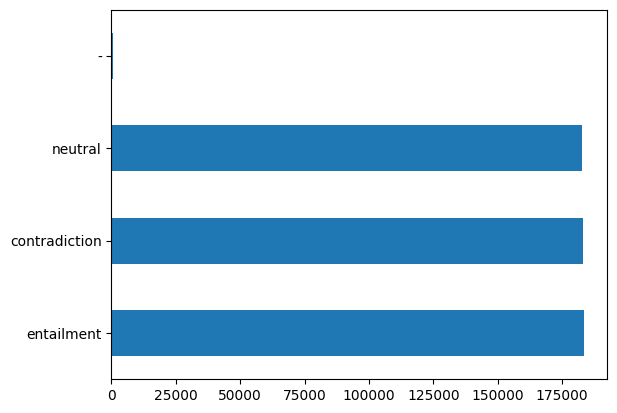

In [5]:
data_df["gold_label"].value_counts().plot(kind="barh")

In [6]:
# let's see a few random contradiction examples
data_df[data_df["gold_label"] == "contradiction"].sample(10)[["sentence1", "sentence2"]]

,sentence1,sentence2
361641,Eine Frau läuft am Strand herum.,Die Frau ist in einem Wald.
90897,Die Streichergruppe tritt im Restaurant auf.,Ein Restaurant ist ruhig.
275929,Ein männlicher Hockeyspieler in einer hellviol...,Der Hockeyspieler befindet sich derzeit auf de...
475007,"Jemand, der eine gute Zeit hat, etwas Teig zu ...","Ein Koch, der Reportern ein Interview gibt."
158522,"Ein Mann, der auf dem Boden neben einem Besen ...",Ein Mann steht da.
206155,Ein Mann im weißen Hemd geht an einem großen b...,Ein Mann fährt mit dem Fahrrad am Bus entlang.
464033,"Eine Gruppe von Menschen, die durch den Wald g...",Eine Gruppe von Leuten auf dem Sofa.
371644,Die jungen Männer haben eine gute Zeit am Strand.,Die Jungs sind in den Bergen.
275735,Kleiner Junge spielt Tennis mit einem schwarzg...,Ein Junge ist auf einem Skateboard.
376616,"Drei Kerle gehen auf einem Ziegelweg, einer hä...",Männer sitzen da und warten auf den Bus.


In [7]:
# let's see a few random entailment examples
data_df[data_df["gold_label"] == "entailment"].sample(10)[["sentence1", "sentence2"]]

,sentence1,sentence2
191725,"Zwei Kinder, ein weißes und ein schwarzes, spi...",Kinder spielen
512355,"Ein Mann kauft auf der Straße ein, während and...",Einige Leute warten.
477275,Der schwarze Hund schaut auf sein Spiegelbild ...,Der Hund ist am Wasser.
539018,"ein Mann, der bei einem Volleyballspiel einen ...",Ein Typ hat Kontakt mit einem Ball aufgenommen.
185836,"Ein schwarzer Mann, der ein Kunstwerk von Frau...",Ein Mann schaut sich ein Kunstwerk an.
1878,Ein Mann parasailt im Kabbelwasser.,"Das Wasser war kabbelig, als der Mann parasail..."
459517,Zwei Kinder spielen auf einer Metallrutsche.,Die Kinder sind im Freien.
301515,Eine Frau mit braunen Haaren wird von ihrem br...,Eine Frau nimmt an einer Dunk Tank Aktivität t...
216455,Tänzer in ähnlichen Outfits posieren auf einer...,Einige Tänzerinnen und Tänzer posieren.
492739,Ein Mann im blauen Hemd läuft bei einem Rennen...,Ein Mann durchläuft ein Rennen.


In [8]:
# let's see a few random neutral examples
data_df[data_df["gold_label"] == "neutral"].sample(10)[["sentence1", "sentence2"]]

,sentence1,sentence2
142605,Ein kleines Mädchen mit Zöpfen fährt auf ihrem...,Ein Mädchen fuhr in den Park.
462464,Ein Kind in einem Kleid schaut auf eine Sprink...,"Ein Mädchen denkt darüber nach, durch eine Spr..."
509572,Eine Frau in gemalten blauen Overalls fügt Kun...,Die Frau malt Kunstwerke auf das Fenster.
291922,Zwei Frauen aus Florida erleben zum ersten Mal...,Im Hintergrund ist ein Schneemann zu sehen.
7225,Eine Menschenmenge versammelte sich und sah au...,Eine Gruppe von Leuten möchte Fotos von der Fl...
186098,Zwei behelmete Polizisten zu Pferd drehen sich...,Zwei Polizisten zu Pferd werden von den Abendn...
115359,"Jemand, der jemandem ein Tattoo gibt.",ein Tätowierer spricht mit der Person.
483460,"Ein Kind mit einer Blume auf dem Kopf, trägt e...",Zwei Kinder spielen zusammen.
412913,Black and White Dog läuft beim Sabbern über ei...,Der Hund ist ein Dalmatiner.
153354,Ein Junge sitzt auf einem Autositz auf dem Rüc...,"Ein Junge, der mit dem Auto unterwegs ist."


In [9]:
# let's takes only the contradictory sentences and converts the dataset instruct format
def convert_to_instruct_format(row):
  sentence1 = row["sentence1"]
  sentence2 = row["sentence1"]

  prompt = """Below is an instruction that describes a task paired with input that provides further context. Write a response that appropriately completes the request."""
  instruction = """Given the following sentence, your job is to generate the negation for it in the json format"""
  input = str(sentence1)
  response = f"""```json{{'orignal_sentence':'sentence1', 'generated_negation':'sentence2'}}```"""

  if len(input.strip()) == 0:
    # prompt + 2 new lines + ###instruction + new line + input + new line + ###response
    text = prompt + "\n\n Instruction:\n" + instruction + "\n### Response:\n" + response
  else:
    text = prompt + "\n\n Instruction:\n" + instruction + "\n### Input:\n" + "\n" + "\n### Response:\n" + response

  # we need 4 columns for auto train, instruction, input, output, text
  return pd.Series([instruction, input, response, text])

In [10]:
new_df = data_df[data_df["gold_label"] == "contradiction"][["sentence1", "sentence2"]].apply(convert_to_instruct_format, axis=1)
new_df.columns = ["instruction", "input", "output", "text"]
new_df.to_csv("snli_instruct.csv", index=False)

In [11]:
new_df.head()

,instruction,input,output,text
1,"Given the following sentence, your job is to g...",Eine Person auf einem Pferd springt über ein z...,"```json{'orignal_sentence':'sentence1', 'gener...",Below is an instruction that describes a task ...
5,"Given the following sentence, your job is to g...",Kinder lächeln und winken der Kamera zu.,"```json{'orignal_sentence':'sentence1', 'gener...",Below is an instruction that describes a task ...
6,"Given the following sentence, your job is to g...",Ein Junge springt auf dem Skateboard in der Mi...,"```json{'orignal_sentence':'sentence1', 'gener...",Below is an instruction that describes a task ...
10,"Given the following sentence, your job is to g...",Ein älterer Mann sitzt mit seinem Orangensaft ...,"```json{'orignal_sentence':'sentence1', 'gener...",Below is an instruction that describes a task ...
13,"Given the following sentence, your job is to g...",Zwei blonde Frauen umarmen sich gegenseitig.,"```json{'orignal_sentence':'sentence1', 'gener...",Below is an instruction that describes a task ...


In [12]:
# let's load the formatted dataset
df = pd.read_csv("snli_instruct.csv")

In [15]:
# let's convert it to the Hugging Face dataset format
dataset = Dataset.from_pandas(df)

##Fine-tuning

We will be using the already quantized LLamav2 model.

In [16]:
# The model that you want to train from the Hugging Face hub
model_name = "abhishek/llama-2-7b-hf-small-shards"

# Fine-tuned model name
fine_tuned_model = "llama-2-contradictor"

################################################################################
#                      QLoRA parameters
################################################################################
# LoRA attention dimension
lora_r = 64
# Alpha parameter for LoRA scaling
lora_alpha = 16
# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
#                     bitsandbytes parameters
################################################################################
# Activate 4-bit precision base model loading
use_4bit = True
# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"
# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"
# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
#                   TrainingArguments parameters
################################################################################
# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"
# Number of training epochs
num_train_epochs = 1
# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False
# Batch size per GPU for training
per_device_train_batch_size = 4
# Batch size per GPU for evaluation
per_device_eval_batch_size = 4
# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1
# Enable gradient checkpointing
gradient_checkpointing = True
# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3
# Initial learning rate (AdamW optimizer)
learning_rate = 1e-5
# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001
# Optimizer to use
optim = "paged_adamw_32bit"
# Learning rate schedule
lr_scheduler_type = "cosine"
# Number of training steps (overrides num_train_epochs)
max_steps = -1
# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03
# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True
# Save checkpoint every X updates steps
save_steps = 0
# Log every X updates steps
logging_steps = 100

################################################################################
#                         SFT parameters
################################################################################
# Maximum sequence length to use
max_seq_length = None
# Pack multiple short examples in the same input sequence to increase efficiency
packing = False
# Load the entire model on the GPU 0
device_map = {"":0}